# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import random
import itertools


from shutil import copyfile, rmtree
from pathlib import Path


from glob import glob

import os
# for dirname, _, filenames in os.walk('/kaggle/input/facial-age/face_age'):
#     print (dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix


In [2]:

INPUT_CLASSES_DIR = '/kaggle/input/facial-age/face_age/'

folders = glob(INPUT_CLASSES_DIR + '*')

ages_dict = {}

for dirname in folders:
    ages_dict[dirname.rsplit('/')[-1]] = len(os.listdir(dirname))

print ('Possible ages:')
ages_dict = dict(sorted(ages_dict.items()))
del[ages_dict['face_age']]

Possible ages:


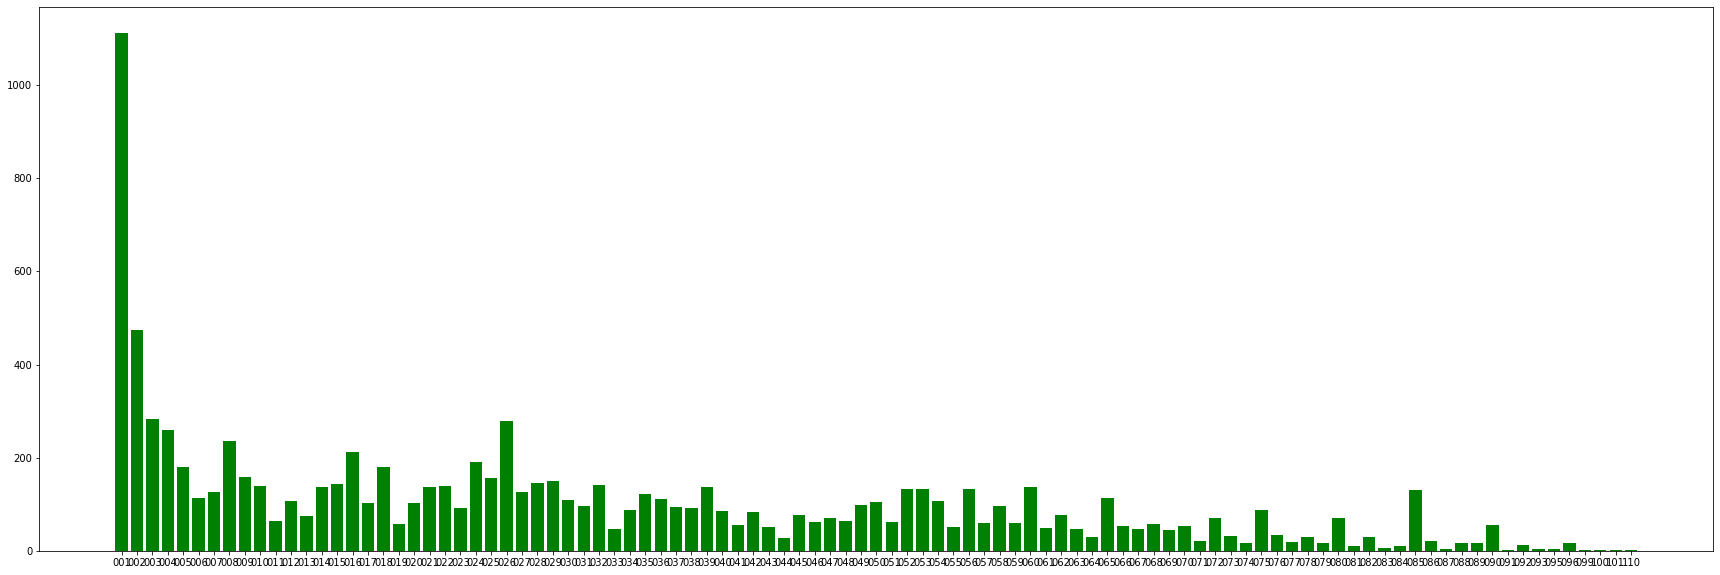

In [3]:
plt.figure(figsize=(30, 10))

plt.bar(list(ages_dict.keys()), ages_dict.values(), color='g')

plt.show()


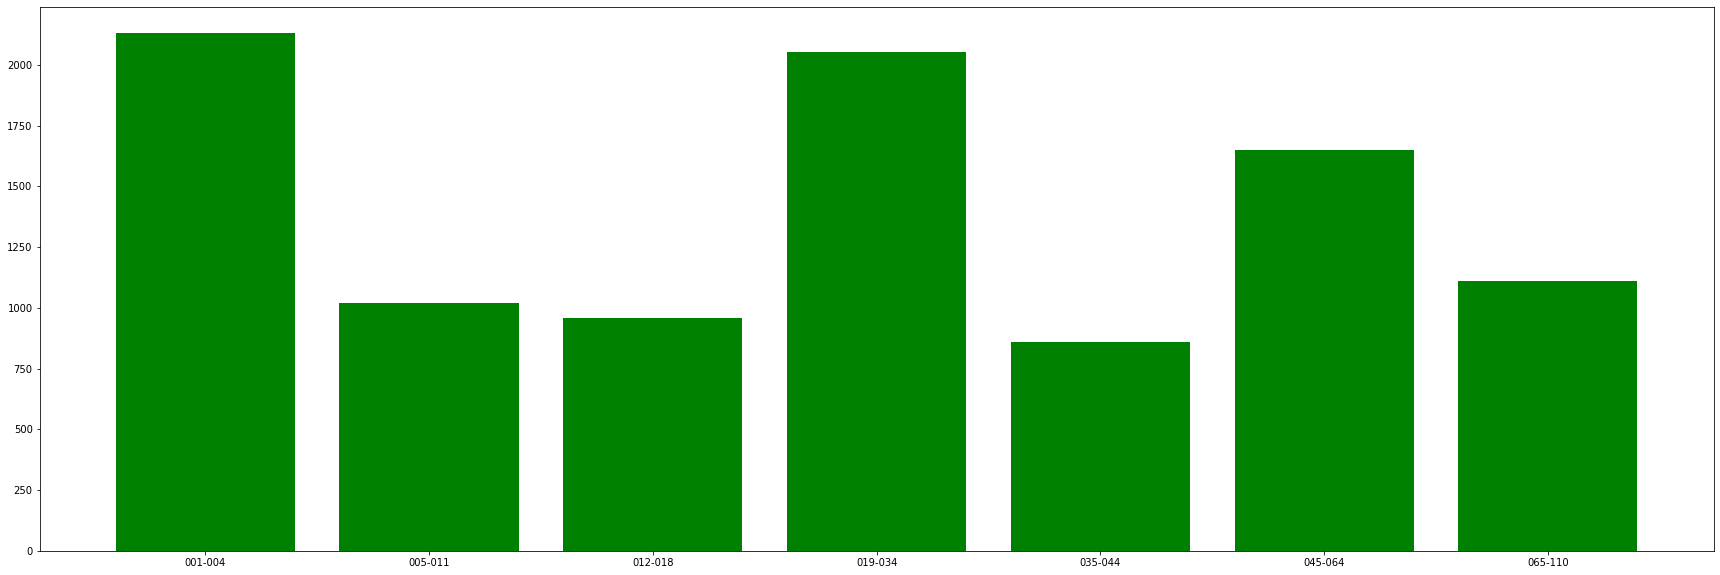

In [4]:
age_splits = [1,5,12,19,35,45,65,111]

age_splits_ranges = [[str(x).rjust(3,"0") for x in list(range(age_splits[idx],age_splits[idx+1]))] for idx in range(len(age_splits)-1)]


age_groups = {}

for age_range in age_splits_ranges:
    total = 0
    for age in age_range:
        if age in ages_dict:
            total += ages_dict[age]
    age_groups[f'{age_range[0]}-{age_range[-1]}'] = total
    
#age_groups
plt.figure(figsize=(30, 10))

plt.bar(list(age_groups.keys()), age_groups.values(), color='g')

plt.show()


In [5]:
age_groups

{'001-004': 2131,
 '005-011': 1018,
 '012-018': 957,
 '019-034': 2055,
 '035-044': 858,
 '045-064': 1648,
 '065-110': 1111}

In [6]:
MIN_COUNT_IN_CLASS = min(age_groups.values())
#MIN_COUNT_IN_CLASS = 40
TRAIN_SAMPLE_SIZE = int(MIN_COUNT_IN_CLASS * 0.85 )
TEST_SAMPLE_SIZE = MIN_COUNT_IN_CLASS - TRAIN_SAMPLE_SIZE

In [7]:
test_root = './test'
train_root = './train'

rmtree(train_root, ignore_errors=True)
rmtree(test_root, ignore_errors=True)

age_groupped_filenames_dict = {}

for age_range in age_splits_ranges:
    Path(f"{test_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    Path(f"{train_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    age_groupped_filenames = []
    for age in age_range:
        full_dirname = INPUT_CLASSES_DIR + age
        age_groupped_filenames.extend(glob(full_dirname + '/*'))
    age_groupped_filenames_dict[f'{age_range[0]}-{age_range[-1]}'] = age_groupped_filenames
    
for age_range in age_groupped_filenames_dict:
    age_sample = random.sample(age_groupped_filenames_dict[age_range], MIN_COUNT_IN_CLASS)
    train_filenames = age_sample[:TRAIN_SAMPLE_SIZE]
    for f in train_filenames:
        copyfile(f, f"{train_root}/{age_range}/{f.split('/')[-1]}")
        
    
    test_filenames = age_sample[TRAIN_SAMPLE_SIZE:]
    for f in test_filenames:
        copyfile(f, f"{test_root}/{age_range}/{f.split('/')[-1]}")

In [8]:
# useful for getting number of files
train_files = glob(train_root + '/*/*.png')
test_files = glob(test_root + '/*/*.png')


In [9]:
print(len(train_files))
print(len(test_files))


5103
903


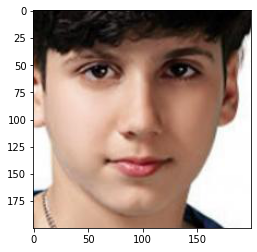

In [10]:
plt.imshow(image.load_img(np.random.choice(train_files)))

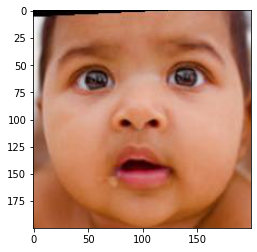

In [11]:
plt.imshow(image.load_img(np.random.choice(test_files)))


In [12]:
# re-size all the images to this
IMAGE_SIZE = [100, 100]

# training config:
epochs = 20
batch_size = 128


# resnet base
res = ResNet50(
input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
loss='sparse_categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

94781440/94765736 [==============================] - 0s 0us/step


In [13]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [14]:
# get label mapping for confusion matrix plot
test_gen = val_gen.flow_from_directory(test_root, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 903 images belonging to 7 classes.
{'001-004': 0, '005-011': 1, '012-018': 2, '019-034': 3, '035-044': 4, '045-064': 5, '065-110': 6}


In [15]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_root,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  test_root,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 5103 images belonging to 7 classes.
Found 903 images belonging to 7 classes.


In [16]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(test_files) // batch_size,
)

Epoch 1/20
39/39 [==============================] - 35s 660ms/step - loss: 4.3052 - accuracy: 0.3674 - val_loss: 2.3829 - val_accuracy: 0.4710
Epoch 2/20
39/39 [==============================] - 24s 619ms/step - loss: 2.3863 - accuracy: 0.4742 - val_loss: 2.1215 - val_accuracy: 0.4632
Epoch 3/20
39/39 [==============================] - 25s 626ms/step - loss: 2.0885 - accuracy: 0.5031 - val_loss: 2.0533 - val_accuracy: 0.5190
Epoch 4/20
39/39 [==============================] - 24s 622ms/step - loss: 2.3419 - accuracy: 0.4953 - val_loss: 2.7638 - val_accuracy: 0.4866
Epoch 5/20
39/39 [==============================] - 24s 620ms/step - loss: 2.3318 - accuracy: 0.5238 - val_loss: 2.2295 - val_accuracy: 0.5179
Epoch 6/20
39/39 [==============================] - 24s 619ms/step - loss: 2.3733 - accuracy: 0.5130 - val_loss: 2.4992 - val_accuracy: 0.4900
Epoch 7/20
39/39 [==============================] - 24s 617ms/step - loss: 2.6110 - accuracy: 0.5164 - val_loss: 2.5491 - val_accuracy: 0.5324

In [25]:
model.save('age.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [17]:
from sklearn.metrics import mean_squared_error


# Faire des prédictions sur les données de validation
y_pred = model.predict(valid_generator)
y_true = valid_generator.classes

# Calculer la MSE
mse = mean_squared_error(y_true, y_pred.argmax(axis=1))

print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.0753045404208195


In [18]:
def get_confusion_matrix(data_path, N):
    # Créer un générateur d'images pour les données de test
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = val_gen.flow_from_directory(
        data_path,
        target_size=IMAGE_SIZE,
        shuffle=False,
        batch_size=batch_size,
        class_mode='sparse'
    )
    
    # Prédire les étiquettes pour les données de test
    y_pred = model.predict(test_generator, steps=len(test_generator))
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Obtenir les étiquettes vraies
    y_true = test_generator.classes
    
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred_classes)
    return cm


In [19]:
cm = get_confusion_matrix(train_root, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(test_root, len(test_files))
print(valid_cm)

Found 5103 images belonging to 7 classes.
[[578 115  28   0   4   1   3]
 [ 20 486 185   9  23   3   3]
 [  1  67 578  14  52  14   3]
 [  1  35 178 201 281  25   8]
 [  0   9  39  23 563  82  13]
 [  0  10  36  11 193 372 107]
 [  0   6  11   2  36  98 576]]
Found 903 images belonging to 7 classes.
[[101  25   2   0   1   0   0]
 [  9  65  46   1   5   0   3]
 [  0  23  88   7   9   2   0]
 [  0   3  37  18  62   9   0]
 [  0   0  10   4  84  29   2]
 [  0   2   5   3  51  40  28]
 [  0   5   4   0  13  22  85]]


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(30, 30))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[578 115  28   0   4   1   3]
 [ 20 486 185   9  23   3   3]
 [  1  67 578  14  52  14   3]
 [  1  35 178 201 281  25   8]
 [  0   9  39  23 563  82  13]
 [  0  10  36  11 193 372 107]
 [  0   6  11   2  36  98 576]]


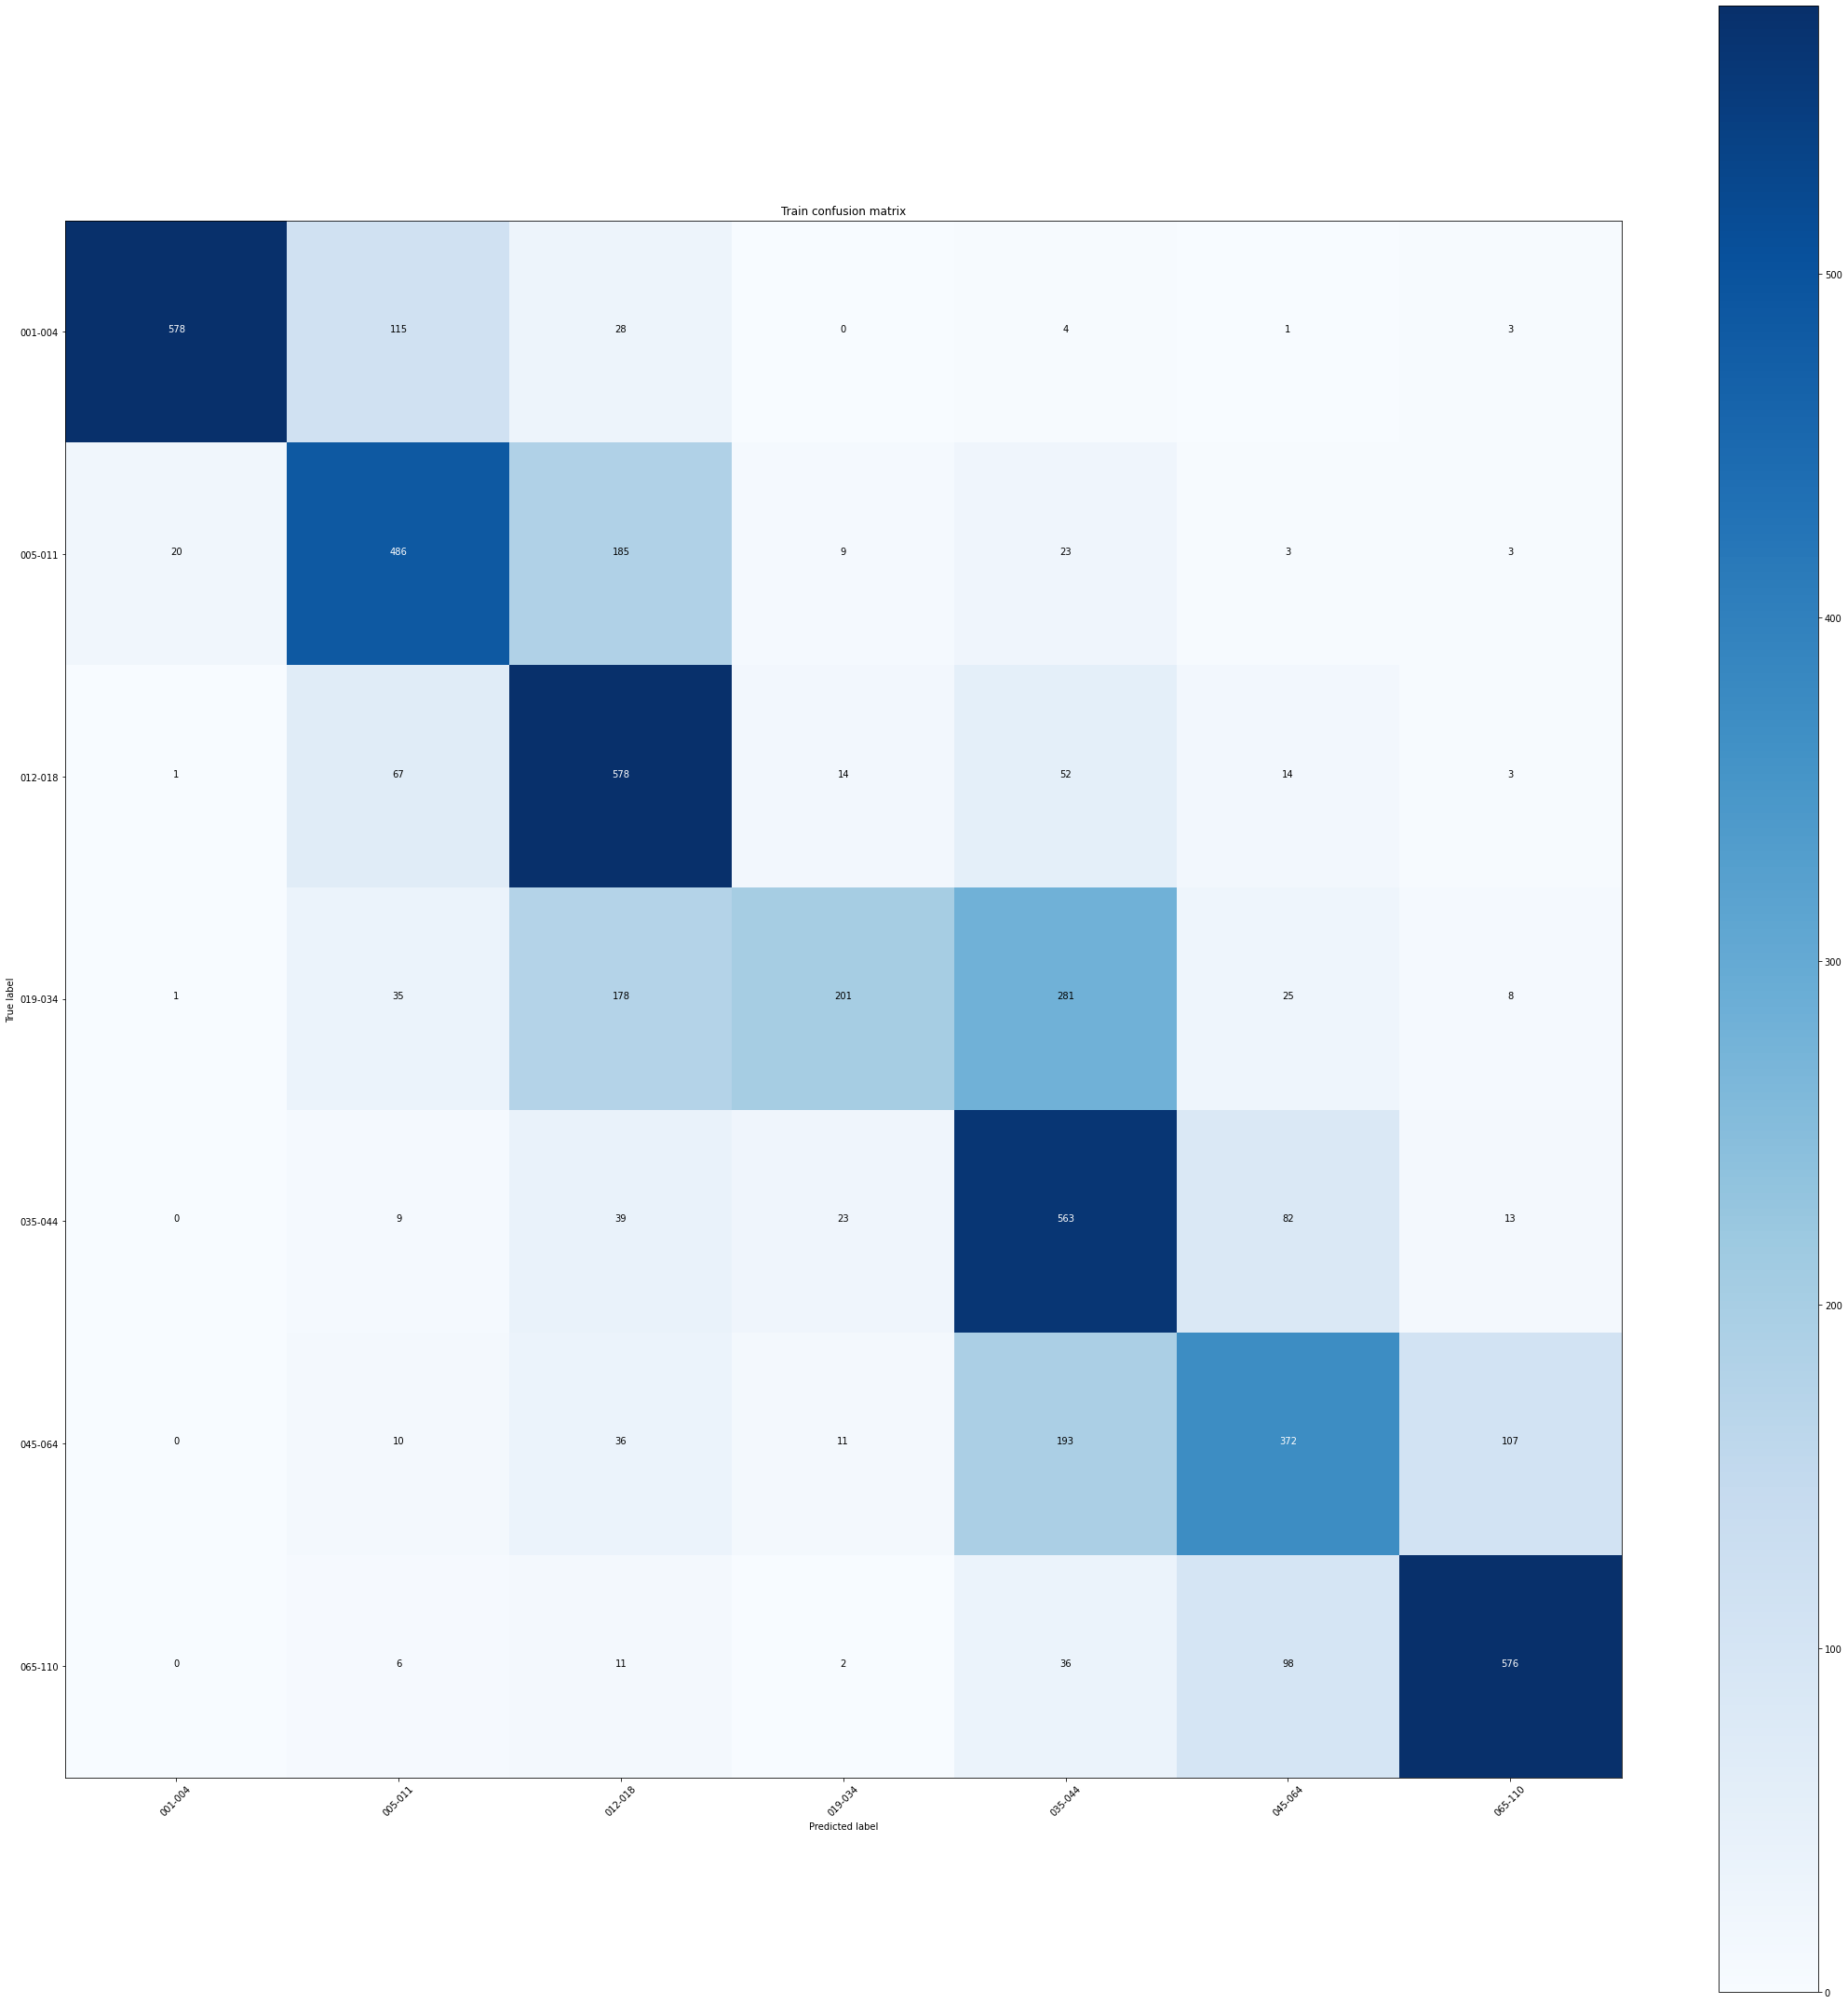

In [21]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')


In [22]:
import requests, io, cv2
import numpy as np
from PIL import Image


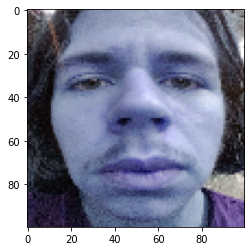

In [36]:
URL = 'https://cdn.discordapp.com/attachments/1209703582841044992/1243523528024916070/IMG_20240524_191818.jpg?ex=6651c908&is=66507788&hm=170c4db06fac1b7d2f88ca1262356a6ef571fa88ee99fae199a3b504dde16932&'
response = requests.get(URL)
bytes_im = io.BytesIO(response.content)
cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.COLOR_RGB2BGR)

internal_image = cv2.resize(cv_im,IMAGE_SIZE)
internal_image = internal_image.reshape(1,IMAGE_SIZE[0], IMAGE_SIZE[1],3) 


plt.imshow(internal_image[0])

In [37]:
p = model.predict(internal_image)
#p = np.argmax(p)
pred_list = {x : float(y) for x,y in zip(labels, p[0])}
pred_list = dict(sorted(pred_list.items(), reverse=True, key=lambda item: item[1]))
pred_list

{'012-018': 0.9010582566261292,
 '045-064': 0.04838475584983826,
 '065-110': 0.04665380343794823,
 '005-011': 0.003903172677382827,
 '001-004': 7.851675754011467e-09,
 '035-044': 1.5397536579087046e-09,
 '019-034': 5.145757153712793e-10}